See https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme/notebook

In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Read training and test sets, sort train set by session start time.

In [3]:
def show_confusion_matrix(y_true,y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true,y_pred)
    fig,ax=plt.subplots(frameon=False)
    fig.set_size_inches(4,3)
    fig.suptitle(title,fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5]*len([0,1]),
                        rowLabels=['True 0','True 1'],colLabels=['Predicted 0','Predicted 1'],
                        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1,4)
    plt.show()

In [4]:
# Load websites dictionary
with open(r"../../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

In [5]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../../../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../../../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


#### Transform data into format which can be fed into CountVectorizer

In [6]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [7]:
!head -5 train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


#### Fit TfidfVectorizer and transform data with it.

In [8]:
%%time
#cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
cv = TfidfVectorizer(ngram_range=(1, 3), max_features=25000)
#cv = TfidfVectorizer(ngram_range=(1, 3), max_df=0.9)

with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

CPU times: user 10.1 s, sys: 217 ms, total: 10.3 s
Wall time: 8.63 s


In [9]:
X_train.shape, X_test.shape

((253561, 25000), (82797, 25000))

In [10]:
X_train.mean(), X_train.min(), X_train.max()

(0.00012341716662171346, 0.0, 1.0)

#### Save train targets into a separate vector.

In [11]:
y_train = train_df['target'].astype('int').values

#### We'll be performing time series cross-validation

We will be performing time series cross-validation, see sklearn TimeSeriesSplit and this dicussion on StackOverflow.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [12]:
time_split = TimeSeriesSplit(n_splits=10)

In [13]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

#### Perform time series cross-validation with logistic regression.

In [14]:
logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs')

In [15]:
%%time
cv_scores = cross_val_score(logit2, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 209 ms, sys: 92.6 ms, total: 302 ms
Wall time: 4.54 s


In [16]:
cv_scores, cv_scores.mean() # 0.8684699030562978

(array([0.83289765, 0.655147  , 0.87907859, 0.9345632 , 0.85022748,
        0.88693684, 0.92149898, 0.87430808, 0.92862062, 0.92201037]),
 0.8685288810778861)

#### Now we'll add some time features: indicators of morning, day, evening and night.

In [17]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse,
                morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1)
                ])
    return X

In [18]:
%%time
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)

CPU times: user 2.34 s, sys: 159 ms, total: 2.5 s
Wall time: 1.2 s


In [19]:
X_train_new.shape, X_test_new.shape

((253561, 25004), (82797, 25004))

In [20]:
X_train_new.mean(), X_train_new.min(), X_train_new.max()

(0.00016339102405786422, 0.0, 1.0)

In [21]:
%%time
cv_scores = cross_val_score(logit2, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 411 ms, sys: 47.2 ms, total: 458 ms
Wall time: 4.5 s


In [22]:
cv_scores, cv_scores.mean() # 0.9242653781514694

(array([0.88325017, 0.80679112, 0.93035949, 0.96539338, 0.91683991,
        0.95117266, 0.94772202, 0.93893161, 0.95187102, 0.95032239]),
 0.9242653781514694)

#### One hot encode the year-month

Not using, seems to lower the cv score

In [23]:
def add_month_categories_feature(df, X_sparse):
    foo = pd.DataFrame(index=df.index)
    foo['start_month_category'] = train_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('category')
    
    onehotencoder = OneHotEncoder(categories='auto')
    foo = onehotencoder.fit_transform(foo).toarray()

    X = hstack([X_sparse, foo])
    return X
    

In [24]:
%%time
X_train_newa = add_month_categories_feature(train_df, X_train_new)
X_test_newa = add_month_categories_feature(test_df, X_test_new)

CPU times: user 2.73 s, sys: 93.2 ms, total: 2.82 s
Wall time: 1.75 s


In [25]:
X_train_newa.shape, X_test_newa.shape

((253561, 25020), (82797, 25020))

In [26]:
%%time
cv_scores = cross_val_score(logit2, X_train_newa, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 860 ms, sys: 55.8 ms, total: 916 ms
Wall time: 4.83 s


In [27]:
cv_scores, cv_scores.mean() # DOWN from 0.9242653781514694

(array([0.87087829, 0.81305674, 0.89412111, 0.96726043, 0.91750997,
        0.94960054, 0.94800434, 0.93661876, 0.93807142, 0.95129616]),
 0.9186417759847252)

#### Add start month feature

In [28]:
def add_start_month_feature(df, X_sparse):
    foo = pd.DataFrame(index=df.index)
    bar = df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')
    # foo['scaled_month'] = StandardScaler().fit_transform(bar.values.reshape(-1, 1))
    #foo['scaled_month'] = Normalizer().fit_transform(bar.values.reshape(-1, 1))
    foo['scaled_month'] = MinMaxScaler().fit_transform(bar.values.reshape(-1, 1))
    
    X = hstack([X_sparse, foo])
    return X

In [29]:
%%time
X_train_new2 = add_start_month_feature(train_df, X_train_new)
X_test_new2 = add_start_month_feature(test_df, X_test_new)

CPU times: user 2.23 s, sys: 41.2 ms, total: 2.27 s
Wall time: 1.15 s


In [30]:
X_train_new2.shape, X_test_new2.shape

((253561, 25005), (82797, 25005))

In [31]:
X_train_new2.mean(), X_train_new2.min(), X_train_new2.max()

(0.00019214020587151438, 0.0, 1.0)

In [32]:
%%time
cv_scores = cross_val_score(logit2, X_train_new2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 677 ms, sys: 44.7 ms, total: 722 ms
Wall time: 4.66 s


In [33]:
cv_scores, cv_scores.mean() # 0.9258065597138293

(array([0.88300658, 0.80753489, 0.9479909 , 0.96752095, 0.91767541,
        0.9509227 , 0.95024515, 0.93829781, 0.9513759 , 0.95034034]),
 0.9264910644841848)

#### Add session length feature

In [34]:
def add_session_length_feature(df, X_sparse):    
    foo = pd.DataFrame(index=df.index)
    foo['min_seconds'] = df[times].min(axis=1)
    foo['max_seconds'] = df[times].max(axis=1)
    foo['seconds'] = (foo['max_seconds'] - foo['min_seconds']) / np.timedelta64(1, 's')

    foo['scaled_session_duration_seconds'] = MinMaxScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    #foo['scaled_session_duration_seconds'] = StandardScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    
    #foo['lt_40_secs'] = (foo['seconds'] < 40)
    #foo['lt_40_secs'] = foo['lt_40_secs'].astype('float64')
    
    foo = foo.drop(columns=['min_seconds', 'max_seconds', 'seconds'])
    
    X = hstack([X_sparse, foo])
    return X
    #return foo

In [35]:
%%time
X_train_new3 = add_session_length_feature(train_df, X_train_new2)
X_test_new3 = add_session_length_feature(test_df, X_test_new2)

CPU times: user 554 ms, sys: 52.9 ms, total: 607 ms
Wall time: 165 ms


In [36]:
X_train_new3.shape, X_test_new3.shape

((253561, 25006), (82797, 25006))

In [37]:
%%time
cv_scores = cross_val_score(logit2, X_train_new3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 872 ms, sys: 58.4 ms, total: 931 ms
Wall time: 4.78 s


In [38]:
cv_scores, cv_scores.mean() # 0.9270225373443463

(array([0.87811861, 0.81039473, 0.94803969, 0.9679063 , 0.91884352,
        0.95220969, 0.95202671, 0.93924959, 0.95271121, 0.95072533]),
 0.9270225373443463)

In [39]:
#logit2.fit(X_train_new3, y_train)

In [40]:
#show_confusion_matrix(y_train, logit2.predict(X_train_new3))

#### Add social network features

In [42]:
facebook_ids = []
youtube_ids = []

for key in list(site_dict.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict[key])
    if 'youtube' in key:
        youtube_ids.append(site_dict[key])
print(youtube_ids)



[38132, 41285, 80, 38133, 15317, 656, 16672, 874, 6581, 38134, 24557, 1307, 12597, 76, 14774, 1345, 74, 16606, 28062, 2329, 1056, 676, 2574, 13347]


In [106]:
def is_site(x, l):
    if x in l:
      return 1 
    return 0

def is_long_session(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 10:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    return 5

In [114]:
def add_social_network_feature(df, X_sparse):    
    foo = pd.DataFrame(index=df.index)
    
    foo['time1'] = df[['time1']].apply(pd.to_datetime)
    # TODO should not fillna, instead find the last date
    foo['time10'] = df[['time10']].fillna('2014-02-20 10:02:45').apply(pd.to_datetime)
    
    
    foo['yb start'] = df['site1'].apply(lambda x: is_site(x, youtube_ids))
    foo['fb start'] = df['site1'].apply(lambda x: is_site(x, facebook_ids))
    
    foo['yb end'] = df['site10'].apply(lambda x: is_site(x, youtube_ids))
    foo['fb end'] = df['site10'].apply(lambda x: is_site(x, facebook_ids))

    
    foo['start day'] = foo['time1'].apply(pd.datetime.weekday)
    
    
    # TODO add sites in addition to youtube and facebook - look at the data exploration for which sites
    # alice uses the most
    
    # Use the second one if used
    #foo['duration'] = (foo['time10'] - foo['time1']).astype(int).apply(lambda x: x/10e8)
    #foo['duration'] = foo['duration'].apply(is_long_session).astype(int)

    
    foo = foo.drop(columns=['time1', 'time10'])
    
    X = hstack([X_sparse, foo])
    return X

In [115]:
%%time
X_train_new4 = add_social_network_feature(train_df, X_train_new3)
X_test_new4 = add_social_network_feature(test_df, X_test_new3)

CPU times: user 6.42 s, sys: 147 ms, total: 6.56 s
Wall time: 5.43 s


In [116]:
X_train_new4.shape, X_test_new4.shape

((253561, 25011), (82797, 25011))

In [117]:
%%time
cv_scores = cross_val_score(logit2, X_train_new4, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 118 ms, sys: 52.8 ms, total: 171 ms
Wall time: 5.1 s


In [119]:
cv_scores, cv_scores.mean() # 0.9269239797946902

(array([0.84151133, 0.80614928, 0.94674724, 0.96827971, 0.91895158,
        0.95892652, 0.94641421, 0.9512764 , 0.96219318, 0.96879035]),
 0.9269239797946902)

In [120]:
logit2.fit(X_train_new4, y_train)

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

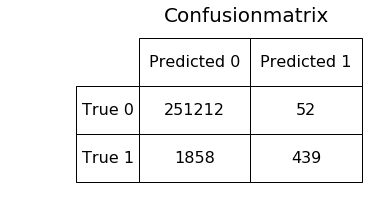

In [121]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

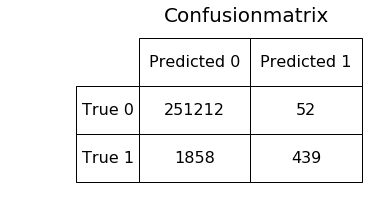

In [122]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

#### Now we tune regularization parameter C.

In [123]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', max_iter=8000)

In [84]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [124]:
#c_values = np.logspace(-2, 2, 10)

params = {
    'C': np.logspace(-2, 2, 10)
#    'penalty': ['l1','l2']
}

logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid=params,
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
#logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid={'C': c_values},
#                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [129]:
%%time
logit_grid_searcher.fit(X_train_new4, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: 

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


CPU times: user 10min 56s, sys: 2.57 s, total: 10min 59s
Wall time: 1min 52s


/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [131]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_ # 0.9277776578977146

(0.9277776578977146, {'C': 1.6681005372000592})

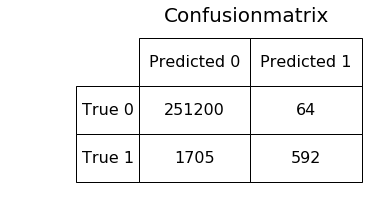

In [132]:
show_confusion_matrix(y_train, logit_grid_searcher.predict(X_train_new4))

In [133]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new4)[:, 1]
write_to_submission_file(logit_test_pred3, 'submissions/14-subm1.csv') # 0.95645
